In [28]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")
from statistics import mean, variance, pstdev


Imports done


In [29]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 1200 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points

In [30]:
#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.zeros(N)
dfmu_x= np.zeros(N)
u = np.zeros(N)

omega_w0 = np.zeros(N)
omega_w1 = np.zeros(N)
omega_z0 = np.zeros(N)
omega_z1 = np.zeros(N)

sigma_w0 = np.zeros(N)
sigma_w1= np.zeros(N)
sigma_z0 = np.zeros(N)
sigma_z1= np.zeros(N)
std = np.zeros(N)

omega_w0[0] = 1
omega_w1[0] = 1
omega_z0[0] = 1
omega_z1[0] = 1

mu_v = np.ones(N)*25
mu_x[0]= 25
x[0] = 30
u[0] = 0

#noise standard deviations and gain
std_noise_x = 0.5
std_noise_y = 1
std_noise_ydot = 0.1

#learning rates
alpha_x = [1,1]
alpha_y = [0.1,0.5]
alpha_mux = 10
alpha_u = 10


# #noise standard deviations and gain
# std_noise_x = 0.5
# std_noise_y = 1
# std_noise_ydot = 0.1

# #learning rates
# alpha_x = [1,1]
# alpha_y = [0.1,0.5]
# alpha_mux = 10
# alpha_u = 10



In [31]:
#create D matrix
def derivativeD(p):
    
    D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))
           
    return D


D = derivativeD(1)

In [32]:
#GM and GP

#Generative process functions
def f_gp(x, u):
    #a = -1
    a = 0 
    b = 1
  
    return a*x + b*u 
def df_gp(x, u):
    a = -1
    #a = 0
    return a



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#generative model functions
def f_gm(mu_x, mu_v):
    
    a = -1 
    b = 1
    return a*mu_x +b*mu_v


def df_gm(mu_x, mu_v):
    
    a = -1
    return a


def g_gm(mu_x,mu_v):

    t0=25
    return t0 -16 / (1 + np.exp(5-mu_x/5))

def dg_gm(mu_x,mu_v):
    
    return -16/5* np.exp(5-mu_x/5) / (np.exp(5-mu_x/5)+1)**2


In [33]:
#initiate mu_x_tilde, Atilde and I
y_tilde = np.zeros((N,2,1))
mu_x_tilde = np.zeros((N,2,1))

#mu_x_tilde[0] = [[mu_x[0]],[0]] #depending on what model you want to start with
mu_x_tilde[0] = [[mu_x[0]],[f_gm(mu_x[0], mu_v[0])]]



Atilde = np.identity(2)*(-1)
I = np.identity(2)


In [34]:
eps_x0_list = []
eps_x1_list = []

eps_y0_list = []
eps_y1_list = []

In [35]:
for i in np.arange(0,N-1):

    #generative process
    x_dot = f_gp(x[i],u[i])  #+ np.random.randn(1)*std_noise_x
    x[i+1] = x[i] + dt*x_dot
    
    y = g_gp(x[i])                      + np.random.randn(1)*std_noise_y
    ydot = dg_gp(x[i])*f_gp(x[i],u[i])  + np.random.randn(1)*std_noise_ydot
    y_tilde[i] = [y,ydot]

    

    # Generative model
    PI_w = np.diag([omega_w0[i],omega_w1[i]])
    PI_z = np.diag([omega_z0[i],omega_z1[i]])
                             
    mu_x_hat = np.array([[1],[0]]) * f_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*df_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
    mu_y_hat = np.array([[1],[0]]) * g_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*dg_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
   
    #prediction error and producing lists for plotting
    eps_x = D.dot(mu_x_tilde[i])-mu_x_hat 
    eps_y = y_tilde[i] - mu_y_hat  
    
    eps_x0_list.append(eps_x[0,0])
    eps_x1_list.append(eps_x[1,0])
    eps_y0_list.append(eps_y[0,0])
    eps_y1_list.append(eps_y[1,0])
    
    #  optimization hidden state
    dFdmu_x = (D-Atilde).T.dot(PI_w).dot(eps_x) - (dg_gm(mu_x[i],mu_v[i]) * I ).T.dot(PI_z).dot(eps_y)
    dmu_x = np.dot(D,mu_x_tilde[i]) - alpha_mux*dFdmu_x #evt alpha toevoegen
    mu_x_tilde[i+1] = mu_x_tilde[i]+ dt*dmu_x
    mu_x[i+1] = mu_x_tilde[i+1,0] #use this for plotting
    dfmu_x[i+1] = mu_x_tilde[i+1,1]

    #optimizing action
    u_dot = -np.array([0,dg_gp(x[i])]).dot(PI_z).dot(eps_y) #dy du simplified because b = 1
    u[i+1] = u[i] + alpha_u*dt*u_dot

    

    #precision optimization
    dPI_w = 0.5*(alpha_x*(inv(PI_w) - np.diag(eps_x.flatten())**2))
    dPI_z = 0.5*(alpha_y*(inv(PI_z) - np.diag(eps_y.flatten())**2))
    PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w0[i+1] = PI_w[0,0]
    omega_w1[i+1] = PI_w[1,1]
    omega_z0[i+1] = PI_z[0,0]
    omega_z1[i+1] = PI_z[1,1]
    
    sigma_w0[i+1] = 1/omega_w0[i+1]
    sigma_w1[i+1] = 1/omega_w1[i+1]
    sigma_z0[i+1] = 1/omega_z0[i+1] 
    sigma_z1[i+1] = 1/omega_z1[i+1]


  

In [38]:
print(np.var(eps_x0_list[200000:]), "eps_x0")
print(np.mean(sigma_w0[200000:]), "sigma_w0")

print(np.var(eps_x1_list[200000:]), "eps_x1")
print(np.mean(sigma_w1[200000:]), "sigma_w1")

print(np.var(eps_y0_list[200000:]), "eps_y0")
print(np.mean(sigma_z0[200000:]), "sigma_z0")

print(np.var(eps_y1_list[200000:]), "eps_y1")
print(np.mean(sigma_z1[200000:]), "sigma_z1")

0.10551928181359312 eps_x0
0.10507422792436867 sigma_w0
0.06051495849626417 eps_x1
0.060695076191553704 sigma_w1
1.0093577537381422 eps_y0
1.0084347773697724 sigma_z0
0.07449730771208328 eps_y1
0.07749612817077109 sigma_z1


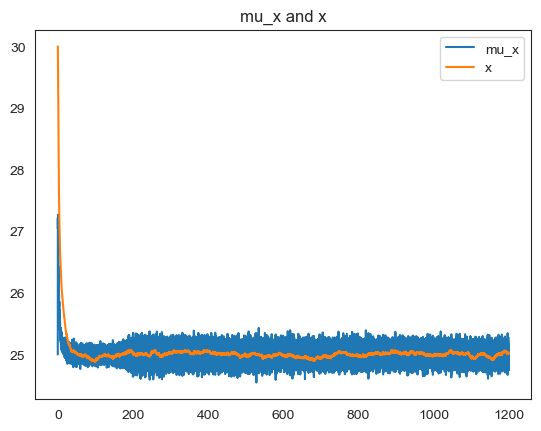

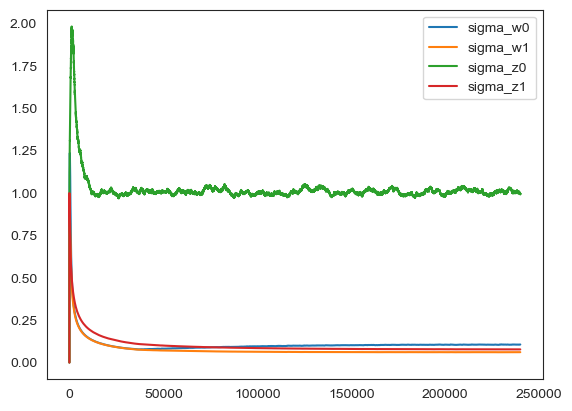

In [37]:
plt.figure()
plt.plot(t,mu_x, label = "mu_x")
plt.plot(t,x, label = "x")
plt.title(label = "mu_x and x")

plt.legend()

plt.figure()
plt.plot(sigma_w0, label = "sigma_w0")
plt.plot(sigma_w1, label = "sigma_w1")
plt.plot(sigma_z0, label = "sigma_z0")
plt.plot(sigma_z1, label = "sigma_z1")
plt.legend()

